<a href="https://colab.research.google.com/github/MengOonLee/LLM/blob/main/References/LangChain/ipynb/T01_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash

pip install --no-cache-dir -qU \
    python-dotenv scrapy unstructured \
    langchain langgraph langchain-core \
    langchain-community langchain-huggingface \
    openai langchain-openai

## LLM

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import dotenv
import langchain_huggingface

_ = dotenv.load_dotenv(dotenv_path=".env", override=True)

# repo_id = "deepseek-ai/DeepSeek-V3.2"
repo_id = "deepseek-ai/DeepSeek-R1-Distill-Llama-70B"
llm_endpoint = langchain_huggingface.HuggingFaceEndpoint(
    huggingfacehub_api_token=os.environ['HF_TOKEN'],
    repo_id=repo_id, task="text-generation",
    provider='auto', temperature=0.1
)
llm = langchain_huggingface.ChatHuggingFace(llm=llm_endpoint)

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")
import dotenv
import openai

_ = dotenv.load_dotenv(dotenv_path=".env", override=True)

client = openai.OpenAI(
    base_url="https://router.huggingface.co/v1",
    api_key=os.environ['HF_TOKEN']
)
completion = client.chat.completions.create(
    model="deepseek-ai/DeepSeek-R1-Distill-Llama-70B",
    messages=[
        {
            "role": "user",
            "content": "What is the capital of France?"
        }
    ],
)

print(completion.choices[0].message)

## Prompt Template

In [2]:
from langchain_core import prompts
import time

service_template = """
Translate the text that is delimited by triple backticks into a
style that is {style}. text: ```{text}```
"""
prompt_template = prompts.ChatPromptTemplate.from_template(
    template=service_template
)

service_style_pirate = """
a polite tone that speaks in English Pirate
"""

service_reply = """
Hey there customer, the warranty does not cover cleaning
expenses for your kitchen because it's your fault that you
misused your blender by forgetting to put the lid on before
starting the blender. Tough luck! See ya!
"""

service_messages = prompt_template.format_messages(
    style=service_style_pirate,
    text=service_reply
)

start_time = time.time()
service_response = llm.invoke(input=service_messages)
end_time = time.time() - start_time
print("Duration: %.2f, Response: %s"%(end_time, service_response.content))

Duration: 14.86, Response: <think>
Alright, so I've got this query where the user wants me to translate some text into a polite pirate-style English. Let me break this down.

First, the original text is pretty straightforward but a bit harsh. It's telling a customer that their warranty doesn't cover cleaning expenses because they misused their blender by not putting the lid on. The tone is kind of blunt, ending with "Tough luck! See ya!" which isn't very friendly.

The user wants this translated into a polite pirate tone. So, I need to maintain the message but make it sound more courteous and pirate-like. Pirates have a distinct way of speaking, using words like "Arrr," "matey," "aye," and phrases that evoke a sense of camaraderie and old-timey speech.

I should start by addressing the customer in a friendly pirate manner. Instead of "Hey there customer," maybe "Ahoy, valued customer!" sounds better. It's more welcoming and sets a positive tone.

Next, the part about the warranty not c

## Output Parsers

In [4]:
from langchain_core import prompts
import time

review_template = """
For the following text, extract the following information:

gift: Was the item purchased as a gift for someone else?
Answer True if yes, False if not or unknown.

delivery_days: How many days did it take for the product
to arrive? If this information is not found, output -1.

price_value: Extract any sentences about the value or price,
and output them as a comma separated Python list.

Format the output as JSON with the following keys:
gift
delivery_days
price_value

text: {text}
"""

prompt_template = prompts.ChatPromptTemplate.from_template(
    template=review_template
)

customer_review = """
This leaf blower is pretty amazing.  It has four settings:
candle blower, gentle breeze, windy city, and tornado. It
arrived in two days, just in time for my wife's anniversary
present. I think my wife liked it so much she was speechless. So
far I've been the only one using it, and I've been using it
every other morning to clear the leaves on our lawn. It's
slightly more expensive than the other leaf blowers out there,
but I think it's worth it for the extra features.
"""

review_messages = prompt_template.format_messages(
    text=customer_review
)

start_time = time.time()
review_response = llm.invoke(input=review_messages)
end_time = time.time() - start_time
print("Duration: %.2f, Response: %s"%(end_time, review_response.content))

Duration: 2.84, Response: ```json
{
  "gift": true,
  "delivery_days": 2,
  "price_value": ["It's slightly more expensive than the other leaf blowers out there, but I think it's worth it for the extra features."]
}
```


## Agent

In [2]:
import datetime
from langchain import tools, agents

@tools.tool
def get_today_date(text: str) -> str:
    """
    Returns todays date, use this for any questions related to
    knowing todays date. The input should always be an empty
    string, and this function will always return todays date -
    any date mathmatics should occur outside this function.
    """
    return "Today is %s"%(str(datetime.date.today()))

agent = agents.create_agent(
    model=llm,
    tools=[get_today_date]
)

response = agent.invoke({
    "messages": [{
        "role": "user",
        "content": "What is the date today?"
    }]
})
print(response['messages'][-1].content)

BadRequestError: (Request ID: Root=1-6965850e-1a5723e8081425eb02d50cab;6bb184e7-6ca7-4e36-8405-8669cb8b8819)

Bad request:

## Tools

In [ ]:
%%bash
pip install --no-cache-dir -qU wikipedia

In [ ]:
from langchain import tools
import wikipedia
import typing

@tools.tool
def wikipedia_tool(
    query: typing.Annotated[str, """
        The Wikipedia search to execute to find key summary information.
    """]
):
    """
    Use this to search wikipedia for factual information.
    """
    try:
        results = wikipedia.search(query)
        if not results:
            return "No results."
        title = results[0]
        summary = wikipedia.summary(title, sentences=8, auto_suggest=False, redirect=True)
    except BaseException as e:
        return f"Error: {repl(e)}"
    return f"Wikipedia summary: {summary}"

company_name = "SWIFT Financial Messaging"
wikipedia_tool.invoke(input=f"{company_name}")

'Wikipedia summary: The Society for Worldwide Interbank Financial Telecommunication (SWIFT), legally S.W.I.F.T. SC, is a cooperative established in 1973 in Belgium (French: Société Coopérative) and owned by the banks and other member firms that use its service. SWIFT provides the main messaging network through which international payments are initiated. It also sells software and services to financial institutions, mostly for use on its proprietary "SWIFTNet", and assigns ISO 9362 Business Identifier Codes (BICs), popularly known as "SWIFT codes".\nAs of 2018, around half of all high-value cross-border payments worldwide used the SWIFT network, and in 2015, SWIFT linked more than 11,000 financial institutions in over 200 countries and territories, who were exchanging an average of over 32 million messages per day (compared to an average of 2.4 million daily messages in 1995).\nSWIFT is headquartered in La Hulpe near Brussels. It hosts an annual conference, called Sibos, specifically ai

## Langgraph Agents

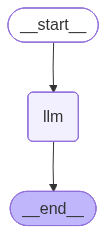

In [ ]:
from typing_extensions import TypedDict
import typing
from langgraph import graph

class GraphState(TypedDict):
    messages: typing.Annotated[list, graph.message.add_messages]

workflow = graph.StateGraph(state_schema=GraphState)

def llm_node(state: GraphState):
    return {"messages": [llm.invoke(state["messages"])]}

workflow.add_node(node="llm", action=llm_node)

workflow.add_edge(start_key=graph.START, end_key="llm")
workflow.add_edge(start_key="llm", end_key=graph.END)
workflow = workflow.compile()
workflow

In [ ]:
for chunk in workflow.stream(
    {"messages": [{
        "role": "user",
        "content": "Tell me about SWIFT ISO20022"
    }]}
):
    print(chunk)

{'llm': {'messages': [AIMessage(content="**SWIFT ISO 20022** is a global messaging standard for financial communications that enhances and modernizes how financial institutions exchange data. Here’s a comprehensive overview:\n\n---\n\n### **1. What is ISO 20022?**\n- **ISO 20022** is an international standard for financial messaging, designed to create a common language and structure for payments, securities, trade finance, and other financial transactions.\n- It enables **richer, structured data** to be attached to payment messages, improving automation, compliance, and transparency.\n\n---\n\n### **2. SWIFT's Role**\n- **SWIFT (Society for Worldwide Interbank Financial Telecommunication)** is the global network that facilitates financial messaging between banks and institutions.\n- Historically, SWIFT used its own message formats (like MT messages). However, SWIFT is now migrating to **ISO 20022** for cross-border payments and reporting, aligning with broader industry adoption.\n\n--